In [ ]:
!nvidia-smi

Fri Oct 20 14:36:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Pre-check before writing Gradio Inferencing (GPU, cpu is damn slow)

In [ ]:
!pip install -q --upgrade transformers diffusers ftfy accelerate gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 78.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 85.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 112.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 134.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 94.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 17.8 MB/s

In [ ]:
import gradio as gr
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms as tfms
import torchvision.transforms.functional as FT
import torchvision.models as models

from PIL import Image
import numpy as np
from diffusers import LMSDiscreteScheduler, DiffusionPipeline

import random
import os
import subprocess

from matplotlib import pyplot as plt
from pathlib import Path
from torch import autocast
from tqdm.auto import tqdm

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch_device)

cpu


In [ ]:
# Define a function to load and preprocess images
def load_image(image_path):
    image = Image.open(image_path)
    preprocess = tfms.Compose([
        tfms.Resize((224, 224)),
        tfms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = preprocess(image).unsqueeze(0)
    return image

# Load a reference image and a generated image
reference_image = load_image("/content/wd7.jpg").to(torch_device)

# Load a pre-trained VGG model (you can use other models as well)
vgg_model = models.vgg16(pretrained=True).features
vgg_model = vgg_model.to(torch_device)

# Define the layers from which to extract features
feature_layers = ["0", "5", "10", "19", "28", "30"]  # These layers capture high-level features

# Create a new model that extracts features from the chosen layers
feature_extractor = nn.Sequential()
for name, layer in vgg_model._modules.items():
    if name == '0':  # Stop at the 28th layer
        break
    feature_extractor.add_module(name, layer)

r_img_extr = feature_extractor(reference_image)
r_img_extr.shape

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 228MB/s]


torch.Size([1, 3, 224, 224])

#### Huggingface

In [ ]:
pretrained_model_name_or_path = "segmind/tiny-sd"
pipe = DiffusionPipeline.from_pretrained(
    pretrained_model_name_or_path,
    torch_dtype=torch.float32
).to(torch_device)

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

vae/diffusion_pytorch_model.safetensors not found


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
concept_dict={'anime_bg_v2':('sd-concepts-library/anime-background-style-v2','<anime-background-style-v2>'),
              'birb':('sd-concepts-library/birb-style','<birb-style>'),
              'beetlejuice':('sd-concepts-library/beetlejuice-cartoon-style','<beetlejuice-cartoon>'),
              'gta5_artwork':('sd-concepts-library/gta5-artwork','<gta5_artwork>'),
              'midjourney':('sd-concepts-library/midjourney-style','<midjourney-style>')}

sd_concepts = []
for concept, value in concept_dict.items():
    sd_concepts.append(value[1])
    pipe.load_textual_inversion(value[0])
sd_concepts

['<anime-background-style-v2>',
 '<birb-style>',
 '<beetlejuice-cartoon>',
 '<gta5_artwork>',
 '<midjourney-style>']

In [ ]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = pipe.vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()  # [1, 4, 64, 64]

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = pipe.vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).np()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [ ]:
def perceptual_loss(images, pattern):
    """
    This function calculates the perceptual loss between the output image and the target image.

    Parameters:
    """
    criterion = nn.MSELoss()
    mse_loss = criterion(images, pattern)
    return mse_loss

In [ ]:
#Generating image with the modified embeddings with pattern loss guidance and saving the images to steps/{concept} folder
def generate_with_embs_pattern_loss(prompts):
    height = 224                        # default height of Stable Diffusion
    width = 224                         # default width of Stable Diffusion
    num_inference_steps = 100            # Number of denoising steps
    guidance_scale = 8                  # Scale for classifier-free guidance
    generator = torch.manual_seed(31) # Seed generator to create the inital latent noise
    batch_size = len(sd_concepts)
    pattern_loss_scale = 20

    text_input = pipe.tokenizer(prompts, padding="max_length", max_length=pipe.tokenizer.model_max_length, truncation=True, return_tensors="pt")
    input_ids = text_input.input_ids.to(torch_device)
    with torch.no_grad():
        text_embeddings = pipe.text_encoder(text_input.input_ids.to(torch_device))[0]

    max_length = text_input.input_ids.shape[-1]
    uncond_input = pipe.tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
    with torch.no_grad():
        uncond_embeddings = pipe.text_encoder(uncond_input.input_ids.to(torch_device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
    print(text_embeddings.shape)

    # Prep Scheduler
    scheduler.set_timesteps(num_inference_steps)

    # Prep latents
    latents = torch.randn((batch_size, pipe.unet.in_channels, height // 8, width // 8),
                           generator=generator,)
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform CFG (Classifier Free Guidance)
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        #### ADDITIONAL GUIDANCE ###
        if (i%2 == 0):
            # Requires grad on the latents
            latents = latents.detach().requires_grad_()

            # Get the predicted x0:
            latents_x0 = latents - sigma * noise_pred
            # latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

            # Decode to image space
            denoised_images = pipe.vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)
            # Calculate loss
            denoised_images_extr = feature_extractor(denoised_images)
            reference_img_extr = feature_extractor(reference_image)
            loss = perceptual_loss(denoised_images_extr, reference_img_extr) * pattern_loss_scale
            # Occasionally print it out
            if i%10==0:
                print(i, 'loss:', loss.item())

            # Get gradient
            cond_grad = torch.autograd.grad(loss, latents)[0]

            # Modify the latents based on this gradient
            latents = latents.detach() - cond_grad * sigma**2

        # Now step with scheduler. compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    return latents

- Reference Image

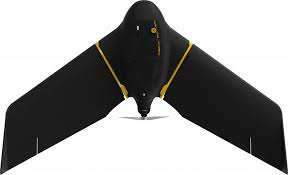

In [ ]:
Image.open('/content/wd7.jpg')

In [ ]:
# Generating images with pattern loss with style. num_inference_steps = 200
suffix_prompt = 'A dog playing in the style of '
prompts = [f'{suffix_prompt} {sd}' for sd in sd_concepts]
latents = generate_with_embs_pattern_loss(prompts)

torch.Size([10, 77, 768])


<ipython-input-12-73a1168a94a0>:27: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, pipe.unet.in_channels, height // 8, width // 8),


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 3, 224, 224])) that is different to the input size (torch.Size([5, 3, 224, 224])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0 loss: 8.025486946105957
10 loss: 6.344804763793945
20 loss: 5.809481620788574
30 loss: 5.262722492218018
40 loss: 4.7313079833984375
50 loss: 4.381394863128662
60 loss: 4.316619873046875
70 loss: 4.3770928382873535
80 loss: 4.3534698486328125
90 loss: 4.340576648712158


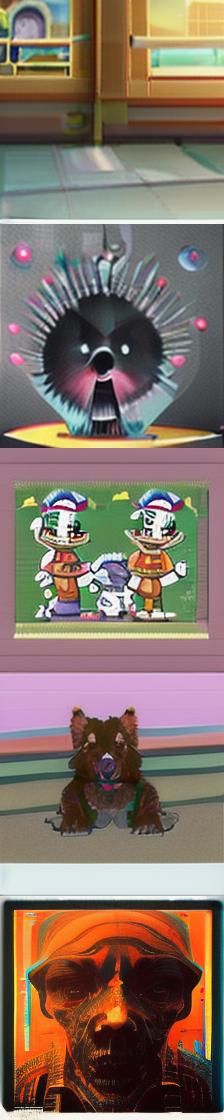

In [ ]:
# original image
images = latents_to_pil(latents)
image_grid(images, len(images), 1)

#### PROMPT : 'A boy running in the style of a tiger'
- 6 Different styles with percpetual loss gudiance

In [ ]:
!mkdir '/content/images_pattern_loss'

In [ ]:
!cp '/content/anime_bg_v2/0199.jpeg' '/content/images_pattern_loss/anime_bg_v2_final.jpeg'
!cp '/content/birb/0199.jpeg' '/content/images_pattern_loss/birb_final.jpeg'
!cp '/content/depthmap/0199.jpeg' '/content/images_pattern_loss/depthmap_final.jpeg'
!cp '/content/gta5_artwork/0199.jpeg' '/content/images_pattern_loss/gta5_artwork_final.jpeg'
!cp '/content/midjourney/0199.jpeg' '/content/images_pattern_loss/midjourney_final.jpeg'

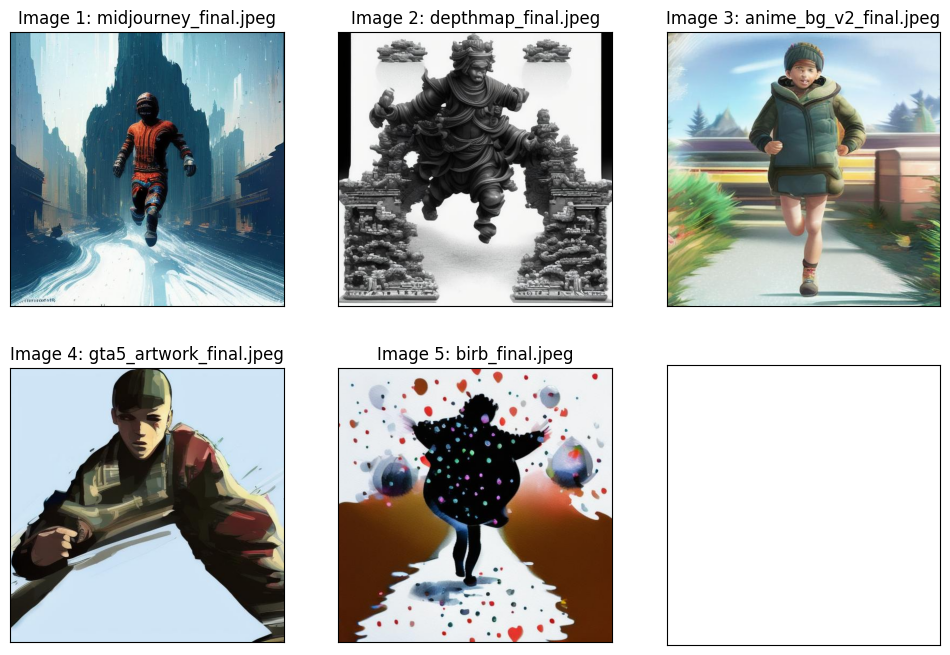

In [ ]:
# Displaying images that were generated for 5 different styles with pattern loss guidnace
# define the folder path where the images are located
folder_path = '/content'

# get the list of image files in the folder
image_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.jpeg')]

# create a new figure with 2 rows and 3 columns
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

# loop through the image files and plot them in the subplot
for i, file in enumerate(image_files[:6]):
    # open the image file using Pillow
    image = Image.open(file)

    # get the current subplot
    ax = axs[i//3, i%3]

    # plot the image
    ax.imshow(image)

    # set the title of the subplot to the image file name
    ax.set_title(f'Image {i+1}: {os.path.basename(file)}')

# hide the x and y axis ticks of the subplots
for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])

# display the subplots
plt.show()

### Gradio Inferencing

In [1]:
!pip install -q --upgrade transformers diffusers ftfy accelerate gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 59.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 83.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 13.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 18.4 MB/s 

In [2]:
import gradio as gr
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms as tfms
import torchvision.models as models

from PIL import Image
import numpy as np
from diffusers import LMSDiscreteScheduler, DiffusionPipeline

import random
import os
import subprocess

from matplotlib import pyplot as plt
from pathlib import Path
from torch import autocast
from tqdm.auto import tqdm

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch_device)

cuda


In [ ]:
print(torch.__version__, torchvision.__version__, gr.__version__)

2.1.0+cu118 0.16.0+cu118 3.50.2


In [ ]:
!pip show diffusers

Name: diffusers
Version: 0.21.4
Summary: State-of-the-art diffusion in PyTorch and JAX.
Home-page: https://github.com/huggingface/diffusers
Author: The HuggingFace team
Author-email: patrick@huggingface.co
License: Apache
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, huggingface-hub, importlib-metadata, numpy, Pillow, regex, requests, safetensors
Required-by: 


In [ ]:
!pip show accelerate

Name: accelerate
Version: 0.23.0
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: sylvain@huggingface.co
License: Apache
Location: /usr/local/lib/python3.10/dist-packages
Requires: huggingface-hub, numpy, packaging, psutil, pyyaml, torch
Required-by: 


In [3]:
# Load a pre-trained VGG model (you can use other models as well)
vgg_model = models.vgg16(pretrained=True).features
vgg_model = vgg_model.to(torch_device)

# Create a new model that extracts features from the chosen layers
feature_extractor = nn.Sequential()
for name, layer in vgg_model._modules.items():
    if name == '0':  # Stop at the 0th layer
        break
    feature_extractor.add_module(name, layer)
feature_extractor = feature_extractor.to(torch_device)

pretrained_model_name_or_path = "segmind/tiny-sd"
pipe = DiffusionPipeline.from_pretrained(
    pretrained_model_name_or_path,
    torch_dtype=torch.float32
).to(torch_device)

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

concept_dict={'anime_bg_v2':('sd-concepts-library/anime-background-style-v2','<anime-background-style-v2>',31),
              'birb':('sd-concepts-library/birb-style','<birb-style>',32),
              'depthmap':('sd-concepts-library/depthmap','<depthmap>',33),
              'gta5_artwork':('sd-concepts-library/gta5-artwork','<gta5_artwork>',34),
              'midjourney':('sd-concepts-library/midjourney-style','<midjourney-style>',35),
              'beetlejuice':('sd-concepts-library/beetlejuice-cartoon-style','<beetlejuice-cartoon>',36)}

cache_style_list = []

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 122MB/s]


unet/diffusion_pytorch_model.safetensors not found


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [4]:
def transform_pattern_image(pattern_image):
    preprocess = tfms.Compose([
        tfms.Resize((320, 320)),
        tfms.ToTensor(),
    ])
    tfms_pattern_image = preprocess(pattern_image).unsqueeze(0)
    return tfms_pattern_image

def load_required_style(style):
    for concept, value in concept_dict.items():
        if style in concept:
            concept_key = value[1]
            concept_seed = value[2]
            if style not in cache_style_list:
                pipe.load_textual_inversion(value[0])
                cache_style_list.append(style)
            break
    return concept_key, concept_seed

def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = pipe.vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()  # [1, 4, 64, 64]

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = pipe.vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

def perceptual_loss(images, pattern):
    """
    This function calculates the perceptual loss between the output image and the target image.

    Parameters:
    """
    criterion = nn.MSELoss()
    mse_loss = criterion(images, pattern)
    return mse_loss

In [5]:
#Generating image with the modified embeddings with pattern loss guidance and saving the images to steps/{concept} folder
def generate_with_embs_pattern_loss(prompt, concept_seed, tfm_pattern_image, num_inf_steps):
    height = 320                        # default height of Stable Diffusion
    width = 320                         # default width of Stable Diffusion
    num_inference_steps = num_inf_steps # Number of denoising steps
    guidance_scale = 8                  # Scale for classifier-free guidance
    generator = torch.manual_seed(concept_seed) # Seed generator to create the inital latent noise
    batch_size = 1
    pattern_loss_scale = 20

    text_input = pipe.tokenizer(prompt, padding="max_length", max_length=pipe.tokenizer.model_max_length, truncation=True, return_tensors="pt")
    input_ids = text_input.input_ids.to(torch_device)
    with torch.no_grad():
        text_embeddings = pipe.text_encoder(text_input.input_ids.to(torch_device))[0]

    max_length = text_input.input_ids.shape[-1]
    uncond_input = pipe.tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
    with torch.no_grad():
        uncond_embeddings = pipe.text_encoder(uncond_input.input_ids.to(torch_device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    scheduler.set_timesteps(num_inference_steps)

    # Prep latents
    latents = torch.randn((batch_size, pipe.unet.in_channels, height // 8, width // 8),
                           generator=generator,)
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform CFG (Classifier Free Guidance)
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        #### ADDITIONAL GUIDANCE ###
        if (i%3 == 0):
            # Requires grad on the latents
            latents = latents.detach().requires_grad_()

            # Get the predicted x0:
            latents_x0 = latents - sigma * noise_pred
            # latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

            # Decode to image space
            denoised_images = pipe.vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)
            # Calculate loss
            denoised_images_extr = feature_extractor(denoised_images)
            reference_img_extr = feature_extractor(tfm_pattern_image)
            loss = perceptual_loss(denoised_images_extr, reference_img_extr) * pattern_loss_scale
            # Get gradient
            cond_grad = torch.autograd.grad(loss, latents)[0]

            # Modify the latents based on this gradient
            latents = latents.detach() - cond_grad * sigma**2

        # Now step with scheduler. compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    return latents

In [6]:
def generate_image(prompt, pattern_image, style, num_inf_steps):
    tfm_pattern_image = transform_pattern_image(pattern_image)  # Transform the pattern image to be fed to feature extractor
    tfm_pattern_image = tfm_pattern_image.to(torch_device)
    if style == "no-style":
        concept_seed = 40
        main_prompt = str(prompt)
    else:
        concept_key, concept_seed = load_required_style(style)
        main_prompt = f"{str(prompt)} in the style of {concept_key}"
    latents = generate_with_embs_pattern_loss(main_prompt, concept_seed, tfm_pattern_image, num_inf_steps)
    generated_image = latents_to_pil(latents)[0]
    return generated_image

In [7]:
def gradio_fn(prompt, pattern_image, style, num_inf_steps):
    output_pil_image = generate_image(prompt, pattern_image, style, num_inf_steps)
    return output_pil_image

In [8]:
demo = gr.Interface(fn=gradio_fn,
                    inputs=[gr.Textbox(info="Example prompt: 'A toddler gazing at sky'"),
                            gr.Image(type="pil", height=224, width=224, info='Sample image to emulate the pattern'),
                            gr.Radio(["anime","birb","depthmap","gta5","midjourney","beetlejuice","no-style"], label="Style",
                                     info="Choose the style in which image to be made"),
                            gr.Slider(50, 200, value=50, label="Num_inference_steps", info="Choose between 50, 10, 150 & 200")],
                    outputs=gr.Image(height=320, width=320),
                    title="ImageAlchemy Using Stable Diffusion",
                    description="- Stable Diffusion model that generates single image to fit \
                                  (a) given text prompt (b) given reference image and (c) selected style.")

In [ ]:
demo.launch(debug=True, share=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://9a89dc2368d899d418.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


<ipython-input-5-6e361e5190a0>:26: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, pipe.unet.in_channels, height // 8, width // 8),


0it [00:00, ?it/s]